# Vision por computadora I - TP1


Por Menara Agustin - menaragustin@gmail.com

Tiempo de ejecución estimado: 200segs

In [1]:
# %matplotlib
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

import os
import time

In [2]:
# Marca temporal para estimar tiempo de ejecución del notebook
since = time.time()

## Parte I

### Coordenadas cromáticas

**Implementar el algoritmo de pasaje a coordenadas cromáticas para librarnos de las variaciones de contraste.**

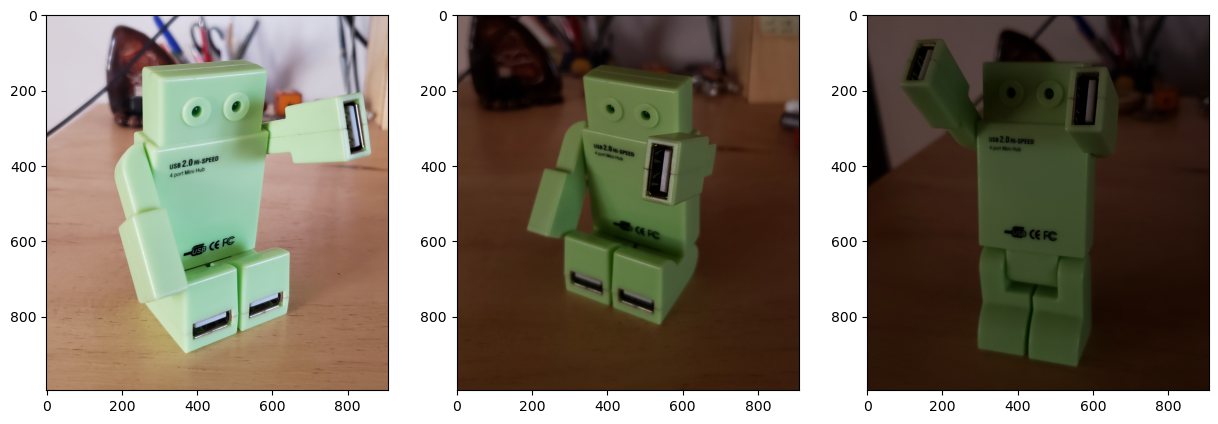

In [3]:
# Exploramos las imágenes disponibles
p1_path1 = './coord_cromaticas/'
imgs_dict = {}

fig, axs = plt.subplots(1,len(os.listdir(p1_path1)),figsize=(15,5))
axs = axs.flatten()
for i,img_name in enumerate(os.listdir(p1_path1)):
    img = cv.imread('/'.join([p1_path1,img_name]))
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    imgs_dict[img_name] = img
    axs[i].imshow(img)
    
plt.show()

El propósito de este primer punto del TP es lograr obtener una imágen común de las tres imágenes de arriba.

Esto lo hacemos implementando el algoritmo de coordenadas cromáticas para independizarnos del contraste.

In [4]:
def coords_crom(img:np.ndarray) -> np.ndarray:
    '''
    Argumentos
    img: Imagen de entrada
    ---------------------------------------
    Retorno
    Imagen: (numpy.ndarray) con coord cromaticas aplicadas
    '''

    # Pasamos a float la matriz imagen
    img = np.array(img,dtype=float)
    # Calculamos la suma de r+g+b para cada pixel
    sum_img = img[:,:,0]+img[:,:,1]+img[:,:,2]

    # Recorremos la imagen pixel por pixel normalizando
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            for c1 in range(3):
                # Salvamos los casos de división por cero
                if sum_img[r,c] != 0:
                    img[r,c,c1] = img[r,c,c1]/sum_img[r,c]
                else:
                    img[r,c,c1] = 0

    return img

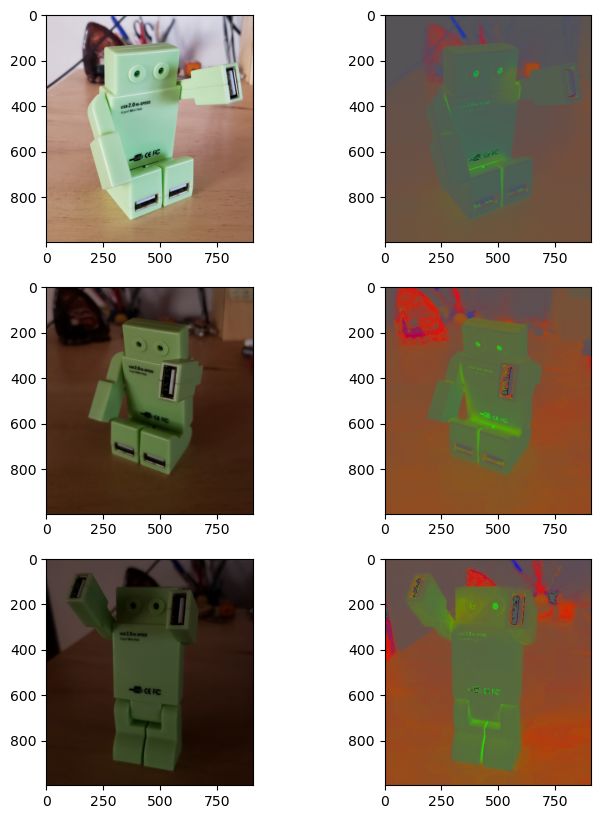

In [5]:
fig,axs = plt.subplots(len(imgs_dict.keys()),2,figsize=(8,10))

for i,item in enumerate(imgs_dict.items()):
    img_name,img = item[0],item[1]
    img_cc = coords_crom(img)
    axs[i][0].imshow(img)
    axs[i][1].imshow(img_cc)

plt.show()

### White patch

**Implementar el algoritmo White Patch para librarnos de las diferencias de color de iluminación.**

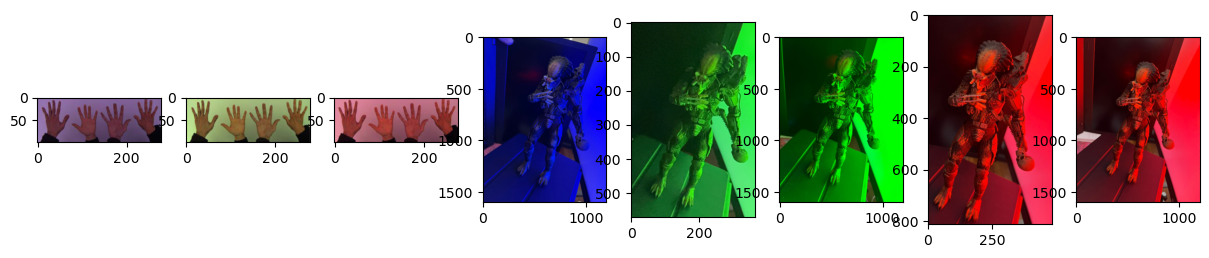

In [6]:
# Exploramos las imágenes disponibles
p1_path1 = './white_patch/'
imgs_dict = {}

fig, axs = plt.subplots(1,len(os.listdir(p1_path1)),figsize=(15,5))
axs = axs.flatten()
for i,img_name in enumerate(os.listdir(p1_path1)):
    img = cv.imread('/'.join([p1_path1,img_name]))
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    imgs_dict[img_name] = img
    axs[i].imshow(img)
    
plt.show()

In [7]:
def white_patch(img:np.ndarray, mode='max') -> np.ndarray:
    '''
    Argumentos
    img: Imagen de entrada
    mode: valor a tomar como denominador 'max' o 'perc'
    ---------------------------------------
    Retorno
    Imagen: (numpy.ndarray) con la correccion aplicada
    '''

    img = np.array(img,dtype=float)

    if mode == 'max':
        r = img[:,:,0].max()
        g = img[:,:,1].max()
        b = img[:,:,2].max()
    elif mode == 'perc':
        r = np.percentile(img[:,:,0], 95)
        g = np.percentile(img[:,:,1], 95)
        b = np.percentile(img[:,:,2], 95)

    factor = [255.0/r, 255.0/g, 255.0/b]

    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            img[r,c,:] = img[r,c,:]*factor

    return np.array(img,dtype=np.uint8)

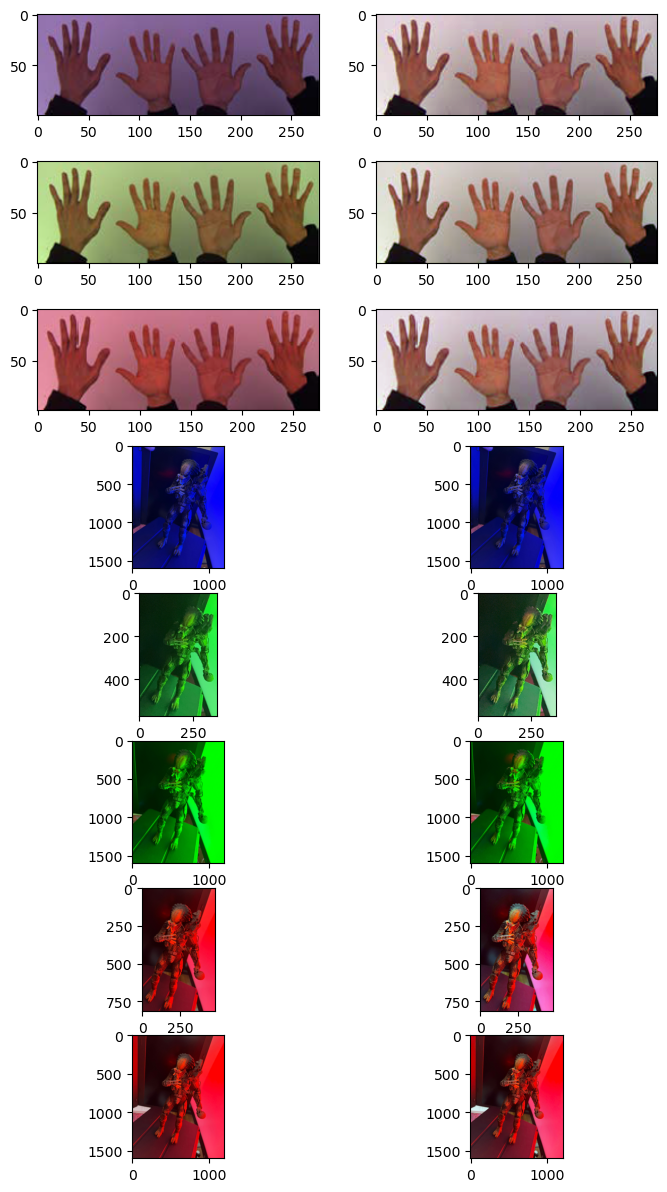

In [8]:
fig,axs = plt.subplots(len(imgs_dict.keys()),2,figsize=(8,15))

for i,item in enumerate(imgs_dict.items()):
    img_name,img = item[0],item[1]
    img_cc = white_patch(img, mode='max')
    axs[i][0].imshow(img)
    axs[i][1].imshow(img_cc)

plt.show()

Funciona bien para las tres primeras imágenes, pero no parece estar funcionando para las otras cinco.

Esto puede deberse a que se tiene que normalizar para otro tipo de luz. Agregamos otro argumento a la función para manejar este factor:

In [9]:
def white_patch(img:np.ndarray, mode:str='max',luz:list=[255,255,255]) -> np.ndarray:
    '''
    Argumentos
    img: Imagen de entrada
    mode: valor a tomar como denominador 'max' o 'perc'
    luz: lista de tres valores int de luz
    ---------------------------------------
    Retorno
    Imagen: (numpy.ndarray) con la correccion aplicada
    '''
    img = np.array(img,dtype=float)

    if mode == 'max':
        r = img[:,:,0].max()
        g = img[:,:,1].max()
        b = img[:,:,2].max()
    elif mode == 'perc':
        r = np.percentile(img[:,:,0], 95)
        g = np.percentile(img[:,:,1], 95)
        b = np.percentile(img[:,:,2], 95)

    factor = [luz[0]/r, luz[1]/g, luz[2]/b]

    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            img[r,c,:] = img[r,c,:]*factor

    return np.array(img,dtype=np.uint8)

Lo probamos en una de las imagenes que fallan:

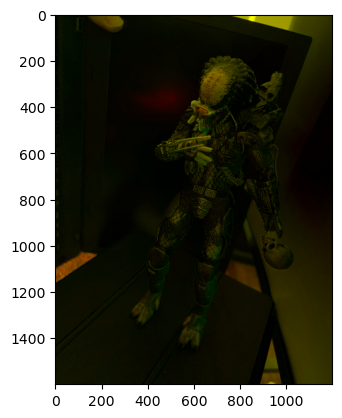

In [10]:
img = imgs_dict[list(imgs_dict.keys())[3]]

img_wp = white_patch(img,luz=[255,255,0])
plt.imshow(img_wp)

Ahora que sabemos que con la luz resolvemos el problema, intentamos automatizar la selección de la luz, analizando qué color es más predominante en cada imagen

In [11]:
def white_patch(img:np.ndarray, mode:str='max',luz:list=[255,255,255]) -> (np.ndarray, list):
    '''
    Argumentos
    img: Imagen de entrada
    mode: valor a tomar como denominador 'max' o 'perc'
    luz: lista de tres valores int de luz
    ---------------------------------------
    Retorno
    Imagen: (numpy.ndarray) con la correccion aplicada
    luz: luz utilizada
    '''
    img = np.array(img,dtype=float)

    if mode == 'max':
        r = img[:,:,0].max()
        g = img[:,:,1].max()
        b = img[:,:,2].max()
    elif mode == 'perc':
        r = np.percentile(img[:,:,0], 95)
        g = np.percentile(img[:,:,1], 95)
        b = np.percentile(img[:,:,2], 95)

    # Se calcula el hist de cada canal
    img_int = np.array(img,dtype=np.uint8)
    hists = []
    for chann in range(3):
        hist1,bins1 = np.histogram(img_int[:,:,chann].ravel(),256,[0,256])
        hists.append(hist1)

    # Se suman los 50 bins mas altos para cada canal
    hists_sum = []
    for h in hists:
        hists_sum.append(sum(h[-50:]))

    # Se apaga el canal que mas valores 255 tenga
    channel_to_off = np.argmax(hists_sum)
    luz[channel_to_off] = 0

    factor = [luz[0]/r, luz[1]/g, luz[2]/b]

    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            img[r,c,:] = img[r,c,:]*factor

    return np.array(img,dtype=np.uint8), luz

Probamos la nueva función automática:

Luz:  [255, 255, 0]


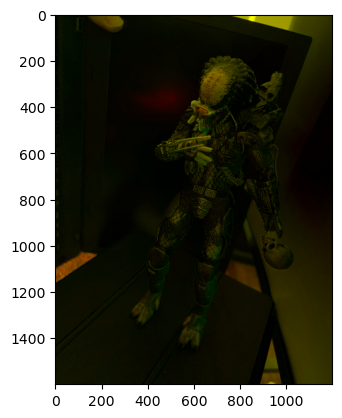

In [12]:
img = imgs_dict[list(imgs_dict.keys())[3]]

img_wp,luz = white_patch(img,mode='max',luz=[255,255,255])
print('Luz: ',luz)
plt.imshow(img_wp)

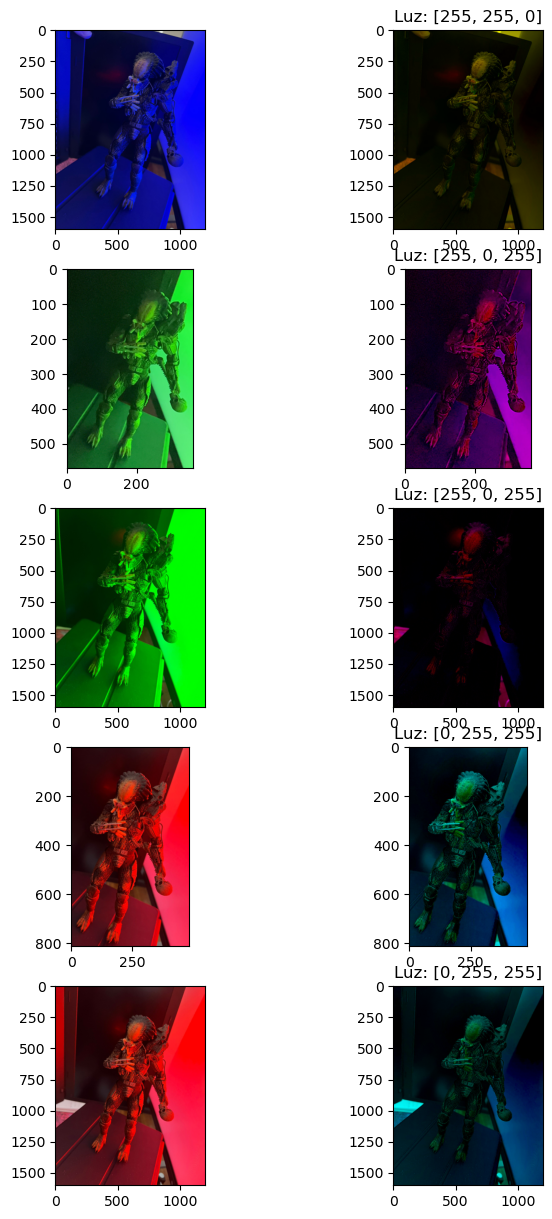

In [13]:
fig,axs = plt.subplots(len(imgs_dict.keys())-3,2,figsize=(8,15))

predator_imgs = list(imgs_dict.keys())[3:]
for i,item in enumerate(predator_imgs):
    img = imgs_dict[item]
    img_wp,luz = white_patch(img, mode='max',luz=[255,255,255])
    axs[i][0].imshow(img)
    axs[i][1].imshow(img_wp)
    axs[i][1].title.set_text(f'Luz: {luz}')

plt.show()

Parece funcionar bastante bien, pero hay una imagen que no se corrige correctamente.

Generamos la siguiente función para ver el impacto de la tranformación en los histogramas de los distintos canales.

In [14]:
def plot_img_hist(img, mode='max',luz=[255,255,255]):
    colors = ['r','g','b']
    fig, axs = plt.subplots(1,4,figsize=(15,5))

    axs[0].imshow(img)

    hists = []
    for chann in range(3):
        hist1,bins1 = np.histogram(img[:,:,chann].ravel(),256,[0,256])
        hists.append(hist1)

    for num,h in enumerate(hists):
        axs[1].plot(h,color=colors[num])

    img_wp, luz1 = white_patch(img, mode=mode, luz=luz)
    axs[2].imshow(img_wp)
    axs[2].set_title(f'Luz: {luz1}')
    
    hists = []
    for chann in range(3):
        hist1,bins1 = np.histogram(img_wp[:,:,chann].ravel(),256,[0,256])
        hists.append(hist1)

    for num,h in enumerate(hists):
        axs[3].plot(h[1:],color=colors[num])

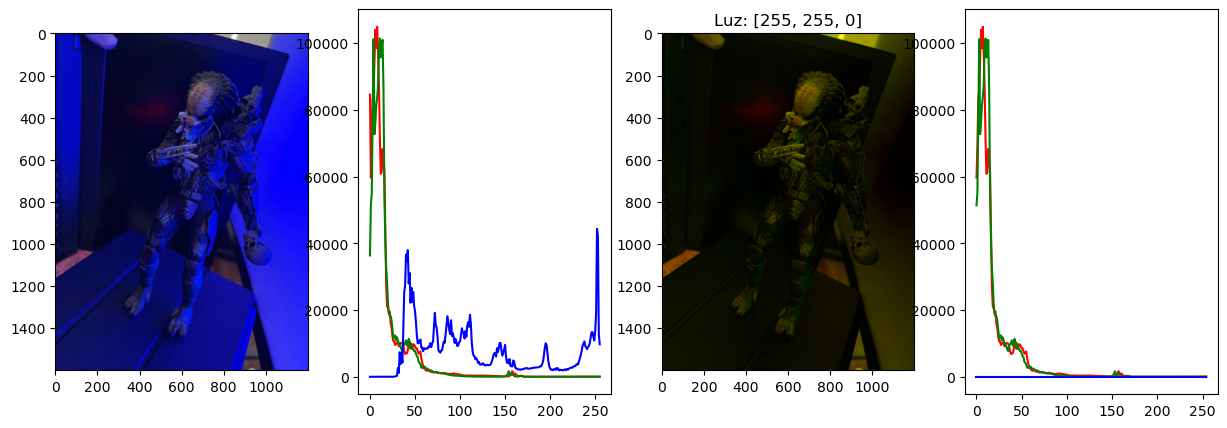

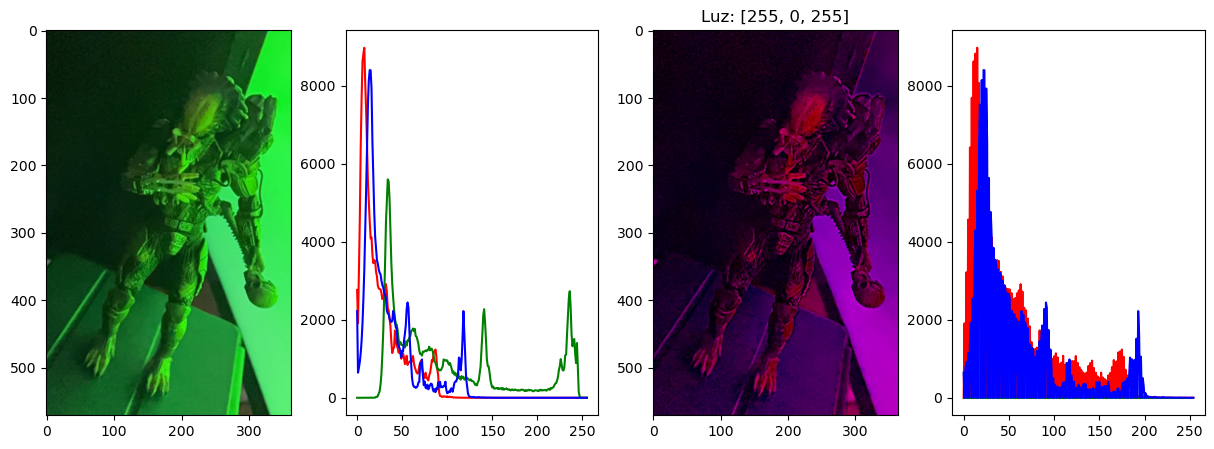

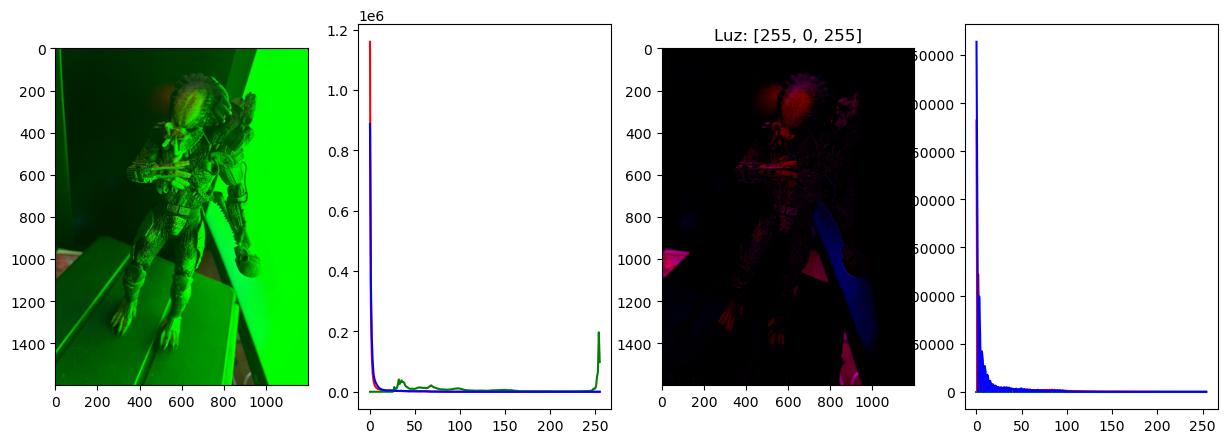

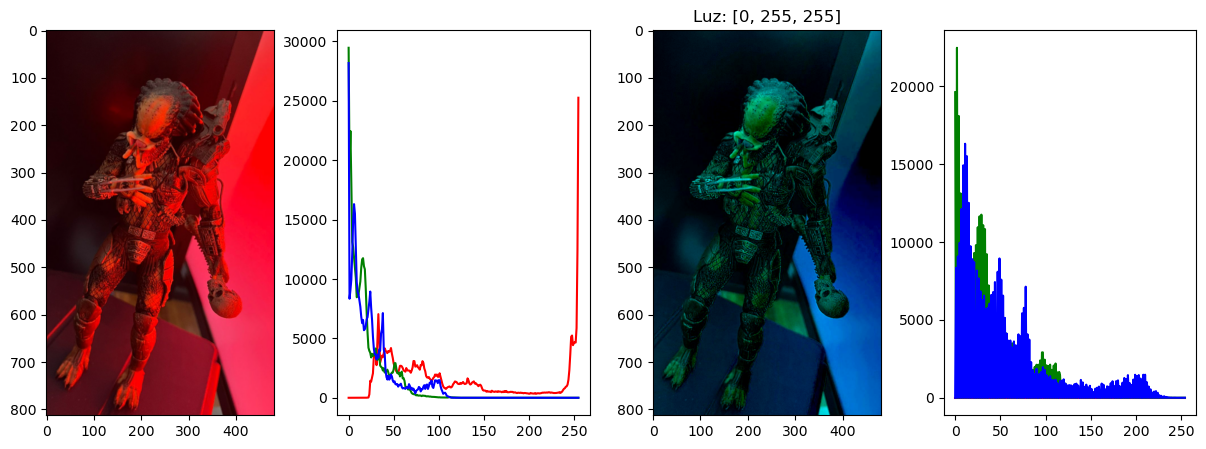

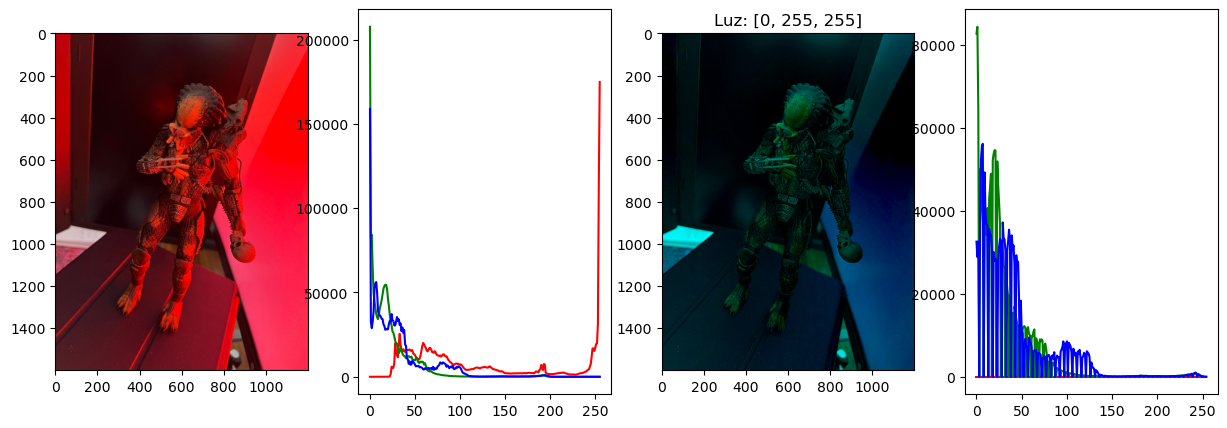

In [15]:
predator_imgs = list(imgs_dict.keys())[3:]

for i,item in enumerate(predator_imgs):
    img = imgs_dict[item]
    plot_img_hist(img,mode='max',luz=[255,255,255])

plt.show()

Se ve como el canal que se debe anular para la luz utilizada en la normalización es la que está "descorrelacionada" con las otras dos.

En el caso de la segunda y tercera imagen donde se anula el canal verde, se pierde el color de la figura original.

Y especificamente en la tercera imagen se observa una gran cantidad de pixeles con valores muy bajos, es como si el brillo se lo estaría dando el color verde, que se anula en la corrección, por eso queda tan oscura la imágen resultante.

Se intenta por último procesar esta imagen con un cambio de brillo para mejorar un poco el resultado:

In [16]:
def change_brightness(input_image:np.ndarray, bright:int) -> np.ndarray: 
    '''
    Argumentos
    img: Imagen de entrada
    bright: Valor porcentual de brillo
    ---------------------------------------
    Retorno
    Imagen: (numpy.ndarray) con el nuevo brillo
    '''
    img_new = img + (255 * bright / 100)
    # Clip trunca a lo que se le diga (0 a 255)
    np.clip(img_new, 0, 255, out = img_new)
    # Hay que castear a 8 bits   
    img_new = img_new.astype('uint8')         

    return img_new

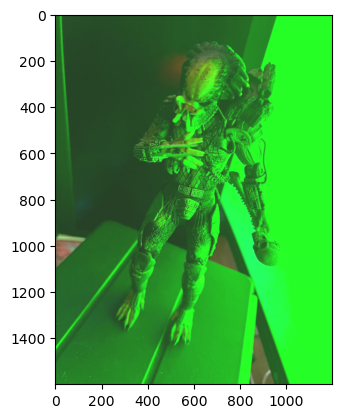

In [17]:
img = imgs_dict[predator_imgs[2]]
img_wp,_ = white_patch(img,mode='max',luz=[255,255,255])
img_wp = change_brightness(img_wp, 15)


plt.imshow(img_wp)
plt.show()

## Parte II

### Histogramas

**Para las imágenes img1_tp.png y img2_tp.png leerlas con OpenCV en escala de grises y visualizarlas.**

Text(0.5, 1.0, 'img2_tp.png')

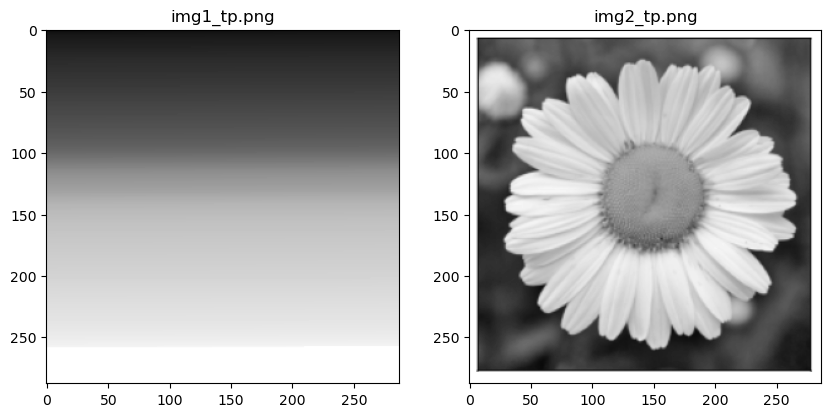

In [18]:
img_path1 = './img1_tp.png'
img_path2 = './img2_tp.png'

img1 = cv.imread(img_path1, cv.IMREAD_GRAYSCALE)
img2 = cv.imread(img_path2, cv.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].imshow(img1, cmap='gray')
axs[0].set_title(img_path1.split('/')[-1])
axs[1].imshow(img2, cmap='gray')
axs[1].set_title(img_path2.split('/')[-1])

**Elija el numero de bins que crea conveniente y grafique su histograma, compare los histogramas entre si.**

In [19]:
def plot_img_hist1(img,bins=256):

    hist1,bins1 = np.histogram(img.ravel(),bins,[0,bins])

    fig, axs = plt.subplots(1,2,figsize=(10,5))

    axs[0].imshow(img, cmap='gray')
    axs[0].set_title('Image')
    axs[1].plot(hist1)
    axs[1].set_title('Histogram')

    plt.show()

    return hist1


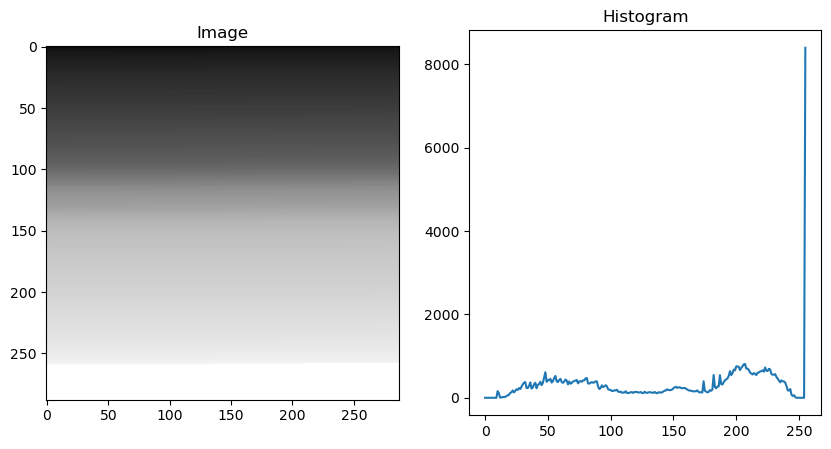

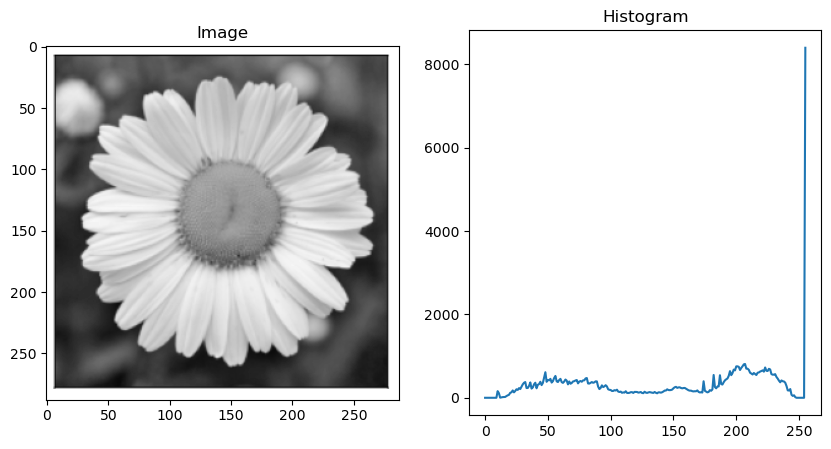

In [20]:
h1 = plot_img_hist1(img1)
h2 = plot_img_hist1(img2)

**Explicar lo que se observa, si tuviera que entrenar un modelo de clasificación/detección de imágenes, 
considera que puede ser de utilidad tomar como ‘features’ a los histogramas?**

Lo interesante de estas dos imágenes es que parecen tener el mismo histograma. Lo verificamos:

In [21]:
np.array_equal(h1,h2)

True

Efectivamente ambas imágenes tienen la misma cantidad de pixeles con cada valor posible de 0 a 256.

Esto llama mucho la atención a primera vista, por la diferencia clara entre ambas imágenes, pero no es algo imposible.

Observando detenidamente la imagen del gradiente de grises, se ve una base de blanco puro que se correponde seguramente con los pétalos de la flor.

La conclusión de este ejercicio es que si bien podría pensarse en los histogramas como una especie de embedding rápido de las imágenes, este caso, si bien es muy particular, pone en evidencia la debilidad de los histogramas, la falta de información sobre la localización o distribución de los píxeles con tal o cual valor.

Por lo tanto, va a depender del problema, pero puede que los histogramas nos sean un buen resumen de imágenes para una clasificación o detección. Por ejemplo si se tiene que discriminar entre morrones rojos y verdes, es muy probable que un histograma sea suficiente, pero si las imágenes a discriminar se diferencian sólo por formas o texturas, no sería un buen recurso



## Parte III

### Segmentación

#### Exploracion inicial

**Para la imagen segmentacion.png analice el histograma de los canales RGB. Segmente algunos de los 
elementos presentes en la imagen (agua, cielo, tierra) y muestre, aplicando mascaras, las regiones en imágenes 
separadas.**

In [22]:
def plot_img_hist2(img,bins=256):
    colors = ['r','g','b']
    hists = []
    for chann in range(3):
        hist1,bins1 = np.histogram(img[:,:,chann].ravel(),bins,[0,bins])
        hists.append(hist1)

    fig, axs = plt.subplots(1,2,figsize=(10,5))

    axs[0].imshow(img, cmap='gray')
    axs[0].set_title('Image')
    for i,h in enumerate(hists):
        axs[1].plot(h,color=colors[i])
    axs[1].set_title('RGB Histogram')

    plt.show()

    return hist1

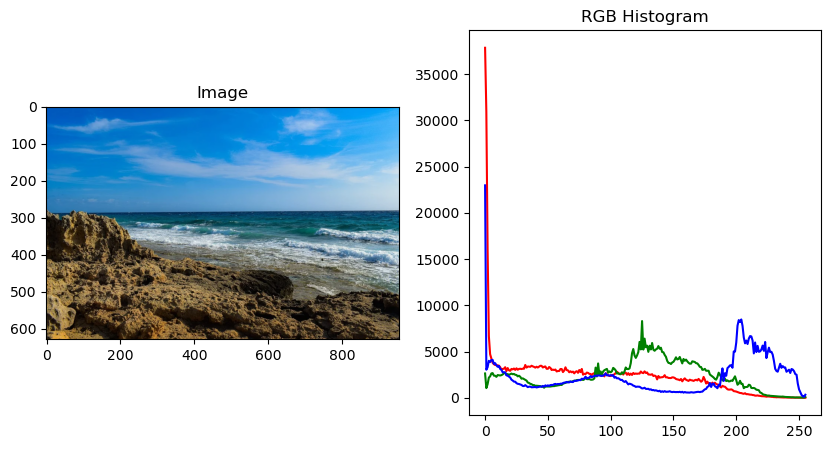

In [23]:
img_seg_path = './segmentacion.png'

img_seg = cv.imread(img_seg_path)
img_seg = cv.cvtColor(img_seg,cv.COLOR_BGR2RGB)

_ = plot_img_hist2(img_seg)

#### Rango dinámico

Como primera estrategia de segmentación se plantea una reducción del rango dinámico a 3 valores de escala de grises:

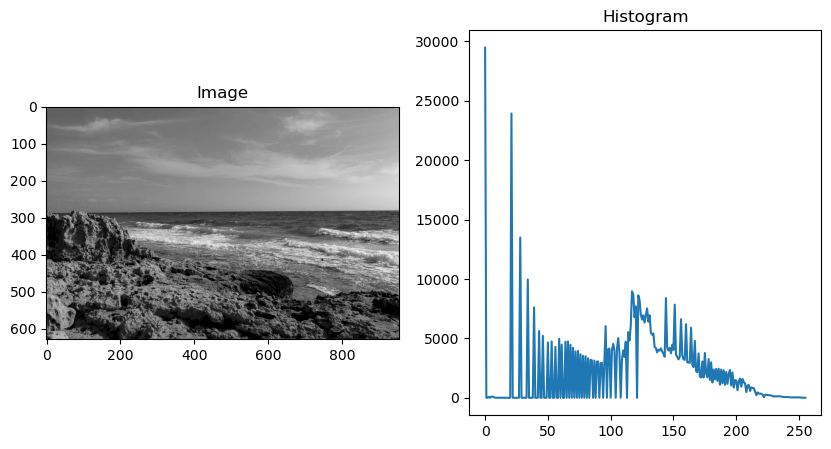

In [24]:
img_seg_gray = cv.imread(img_seg_path, cv.IMREAD_GRAYSCALE)
h1 = plot_img_hist1(img_seg_gray)

Generamos crops de los tres elementos a segmentar: mar, cielo y rocas

Valor medio de pixel:  78.506


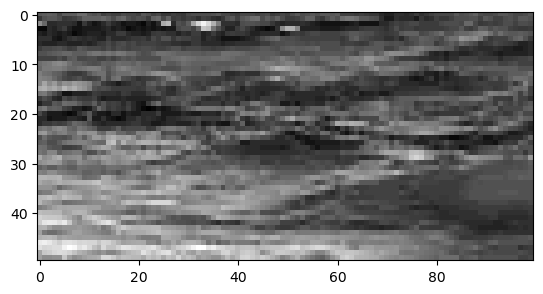

In [25]:
sea = img_seg_gray[300:350,600:700]
print('Valor medio de pixel: ', sea.mean())
plt.imshow(sea, cmap='gray')
plt.show()

Valor medio de pixel:  150.4394


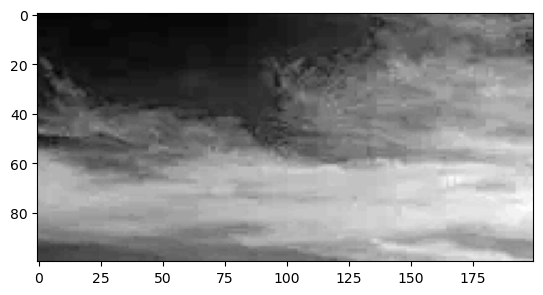

In [26]:
sky = img_seg_gray[100:200,400:600]
print('Valor medio de pixel: ', sky.mean())
plt.imshow(sky, cmap='gray')
plt.show()

Valor medio de pixel:  81.4816


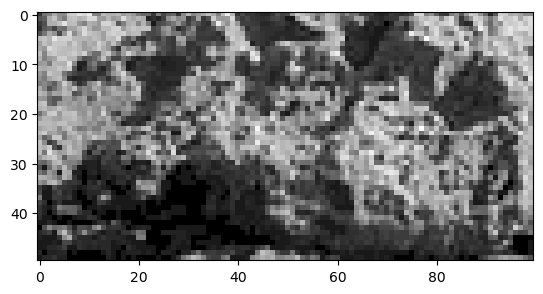

In [27]:
rocks = img_seg_gray[500:550,100:200]
print('Valor medio de pixel: ',rocks.mean())
plt.imshow(rocks, cmap='gray')
plt.show()

No hay una diferenciaición muy clara entre los elementos, pero se intenta de todas formas

In [28]:
mask = []

# Limites de valores de pixel
l1 = 100
l2 = 200

for r in range(img_seg_gray.shape[0]):
    for c in range(img_seg_gray.shape[1]):
        if img_seg_gray[r,c] < l1:
            mask.append([255,0,0])
        elif img_seg_gray[r,c] >= l1 and img_seg_gray[r,c] < l2:
            mask.append([0,255,0])
        else:
            mask.append([0,0,255])

mask = np.array(mask)
mask = mask.reshape(img_seg_gray.shape[0],img_seg_gray.shape[1],3)


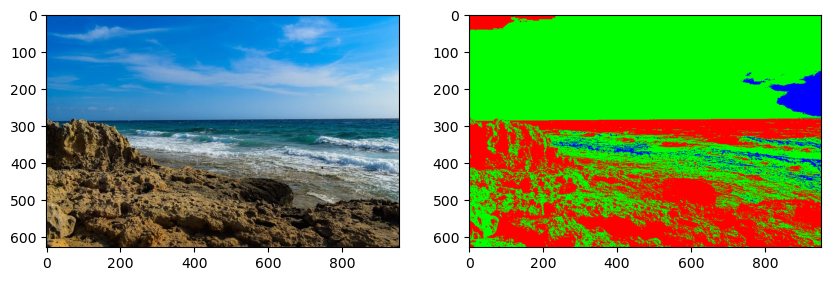

In [29]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].imshow(img_seg)
axs[1].imshow(mask)
plt.show()

Está claro que no podemos descartar la información del color para esta tarea.

#### Espacio de color RGB

La siguiente opción es utilizar los espacios de color para segmentar, comenzamos por RGB:

Analizamos la distribución de colores en este espacio

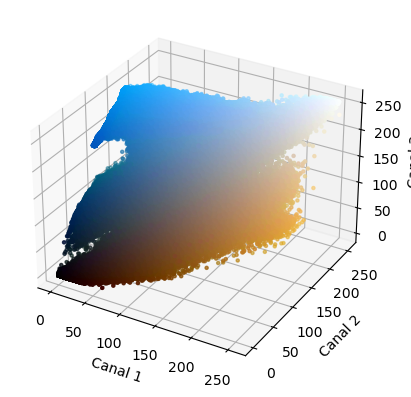

In [30]:
imgRGB = img_seg
c1, c2, c3 = cv.split(imgRGB)

fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = imgRGB.reshape((np.shape(imgRGB)[0]*np.shape(imgRGB)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(c1.flatten(), c2.flatten(), c3.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Canal 1")
axis.set_ylabel("Canal 2")
axis.set_zlabel("Canal 3")
plt.show()

No pareciera haber una buena separación de colores, ni una distribución normal que nos facilite la utilización de media y varianza para filtrar elementos de la imagen. Lo probamos:

In [31]:
def get_mask_RGB(img, crop, n_sigma=3):

    crop = img[crop[0]:crop[1],crop[2]:crop[3],:]

    color_mean ,color_std = cv.meanStdDev(crop)

    mask = cv.inRange(img, color_mean-color_std * n_sigma,  color_mean+color_std * n_sigma)
    img_segmentada = cv.bitwise_and(img, img, mask=mask)


    fig, axs = plt.subplots(1,2,figsize=(10,5))
    axs[0].imshow(img)
    axs[0].set_title('Original Image')
    axs[1].imshow(img_segmentada)
    axs[1].set_title('Segmentation')
    plt.show()

Mar


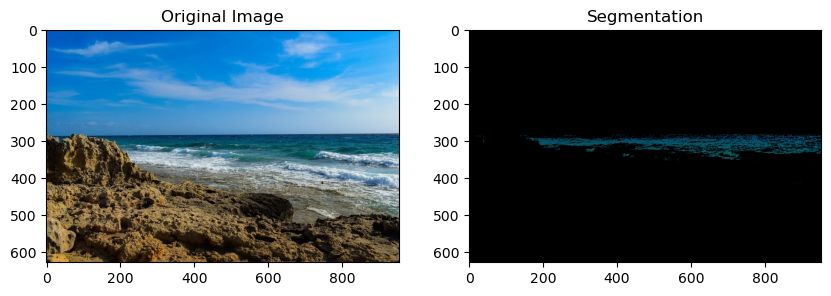

Cielo


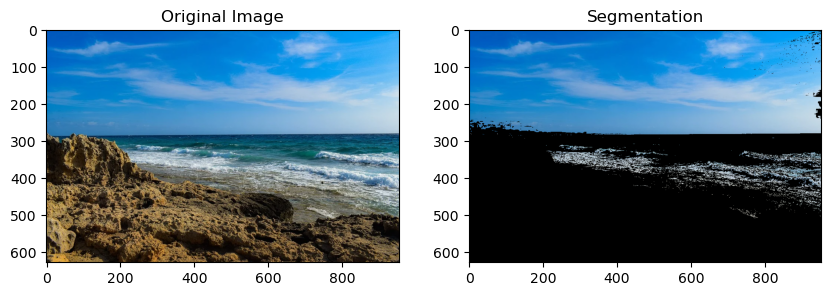

Rocas


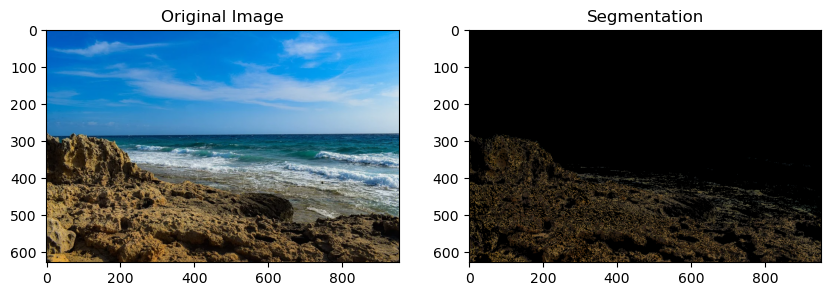

In [32]:
# Crops de los elementos de la imagen 
sea_crop = [300,325,400,-1]
sky_crop = [50,250,100,800]
rocks_crop = [500,600,50,300]

print('Mar')
get_mask_RGB(img_seg, sea_crop, n_sigma=1)
print('Cielo')
get_mask_RGB(img_seg, sky_crop, n_sigma=3)
print('Rocas')
get_mask_RGB(img_seg, rocks_crop, n_sigma=1)


Con modelos probabilisticos basados en color se puede separar lo que son las rocas pero el problema más dificil es separar el cielo del mar, por el color blanco de la espuma y las nubes. Es por esto que la mejor detección del mar es con un sigma bien bajo, de lo contrario se filtran porciones de los otros dos elementos. Con el cielo pasa algo parecido y se asocia la espuma inevitablemente. Las rocas son lo que mejor se puede separar, por su falta de tonos comunes con las otras dos partes.

No son resultados óptimos pero es una mejora respecto a la cuantización anterior.

#### Espacio de color HSV

Ahora probamos con HSV:

Analizamos la distribución de colores en este espacio.

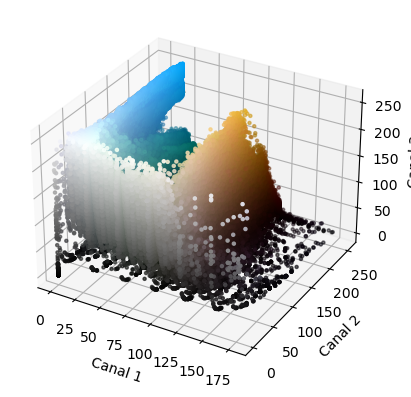

In [33]:
imgRGB = img_seg
img_HSV = cv.cvtColor(img_seg, cv.COLOR_BGR2HSV)

c1, c2, c3 = cv.split(img_HSV)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = imgRGB.reshape((np.shape(imgRGB)[0]*np.shape(imgRGB)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(c1.flatten(), c2.flatten(), c3.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Canal 1")
axis.set_ylabel("Canal 2")
axis.set_zlabel("Canal 3")
plt.show()

Se puede ver una separación un poco más clara de los canales en este espacio.

In [34]:
def get_mask_HSV(img, crop, t=10, t1=100, t2=100):

    img_HSV = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    img_muestra_hsv = img_HSV[crop[0]:crop[1],crop[2]:crop[3],:]

    color_mean = cv.mean(img_muestra_hsv)

    color_l = (color_mean[0]-t, color_mean[1]-t1, color_mean[2]-t2)
    color_u = (color_mean[0]+t, color_mean[1]+t1, color_mean[2]+t2)

    mask = cv.inRange(img_HSV, color_l,  color_u)
    img_segmentada = cv.bitwise_and(img, img, mask=mask)

    fig, axs = plt.subplots(1,2,figsize=(10,5))
    axs[0].imshow(img)
    axs[0].set_title('Original Image')
    axs[1].imshow(img_segmentada)
    axs[1].set_title('Segmentation')
    plt.show()

Mar


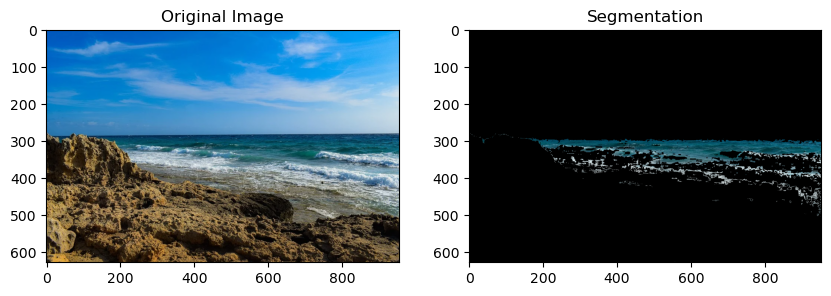

Cielo


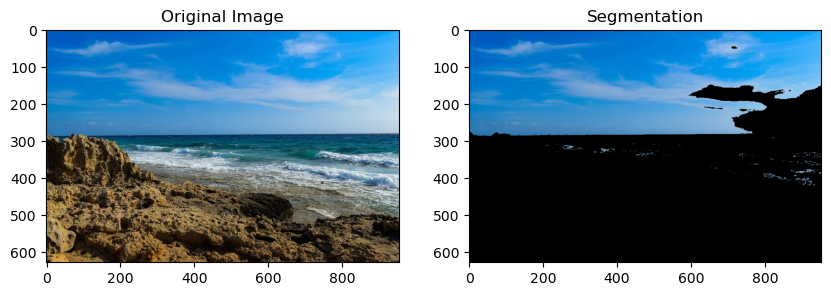

Rocas


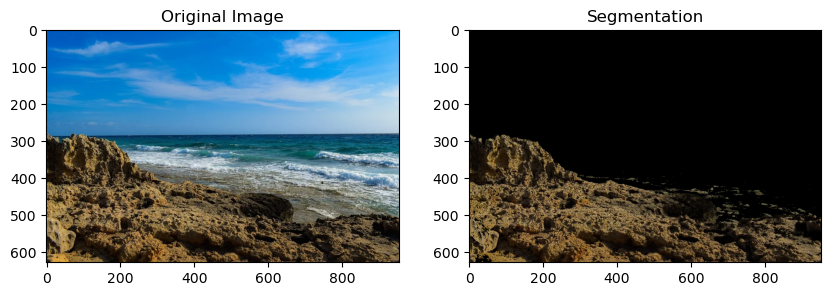

In [35]:
# Crops de los elementos en la imagen
sea_crop = [300,400,400,-1]
sky_crop = [0,250,0,-1]
rocks_crop = [500,600,50,300]

print('Mar')
get_mask_HSV(img_seg, sea_crop, t=3,t1=250,t2=250)
print('Cielo')
get_mask_HSV(img_seg, sky_crop,t=50,t1=105,t2=50)
print('Rocas')
get_mask_HSV(img_seg, rocks_crop, t=50)


Con el espacio de color HSV se logra la mejor segmentación de los tres elementos. Se puede observar una separación bastante buena en lo que es rocas y mar, mientras que en el cielo se consigue un balance entre el blanco en las nubes y la espuma del mar.

In [36]:
to = time.time()

print('Tiempo de ejecución total: ', round(to-since), 'secs.')

Tiempo de ejecución total:  194 secs.
